In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def load_and_preprocess(file_path, freq='D'):
    """
    Загружает данные из CSV, преобразует дату, сортирует по времени,
    устанавливает индекс, обрабатывает пропуски и устанавливает частоту.

    :param file_path: Путь к CSV файлу
    :param freq: Частота временного ряда (например, 'D' для ежедневной)
    :return: Обработанный временной ряд (pandas Series)
    """
    df = pd.read_csv(file_path)

    df['startTime'] = pd.to_datetime(df['startTime'])

    df = df.sort_values('startTime')

    df = df[~df.index.duplicated(keep='first')]

    df.set_index('startTime', inplace=True)

    ts = df['closePrice']

    ts = ts.interpolate(method='linear')

    if ts.isnull().sum() > 0:
        print(f"Найдено {ts.isnull().sum()} оставшихся пропусков после интерполяции. Заполнение методом 'ffill'.")
        ts = ts.fillna(method='ffill')

    if ts.isnull().sum() > 0:
        print(f"Найдено {ts.isnull().sum()} оставшихся пропусков. Заполнение методом 'bfill'.")
        ts = ts.fillna(method='bfill')

    ts = ts.asfreq(freq)

    if ts.isnull().sum() > 0:
        print(f"Найдено {ts.isnull().sum()} пропусков после установки частоты. Заполнение методом 'interpolate'.")
        ts = ts.interpolate(method='linear')

    if ts.isnull().sum() > 0:
        raise ValueError("Временной ряд содержит пропуски после всех попыток заполнения. Проверьте исходные данные.")

    if not pd.api.types.is_numeric_dtype(ts):
        print("Преобразование временного ряда к числовому типу данных.")
        ts = pd.to_numeric(ts, errors='coerce')
        ts = ts.fillna(method='ffill').fillna(method='bfill')

    return ts

def plot_time_series(ts, title='Временной Ряд', ylabel='Цена Закрытия'):
    plt.figure(figsize=(12,6))
    plt.plot(ts, label='Цена закрытия')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def arima_model(ts_train, ts_test, steps=30):
    """
    Строит модель ARIMA с помощью auto_arima и выполняет прогнозирование.

    :param ts_train: Обучающая выборка (pandas Series)
    :param ts_test: Тестовая выборка (pandas Series)
    :param steps: Количество шагов для прогноза
    :return: Модель, прогноз, доверительные интервалы
    """
    print("Построение модели ARIMA...")
    model = auto_arima(
        ts_train,
        start_p=1,
        start_q=1,
        max_p=3,
        max_q=3,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(model.summary())

    forecast, conf_int = model.predict(n_periods=len(ts_test), return_conf_int=True)

    forecast_series = pd.Series(forecast, index=ts_test.index)
    conf_int_df = pd.DataFrame(conf_int, index=ts_test.index, columns=['lower', 'upper'])

    return model, forecast_series, conf_int_df

def sarima_model(ts_train, ts_test, seasonal_period=7, steps=30):
    """
    Строит модель SARIMA с помощью auto_arima и выполняет прогнозирование.

    :param ts_train: Обучающая выборка (pandas Series)
    :param ts_test: Тестовая выборка (pandas Series)
    :param seasonal_period: Сезонный период (m)
    :param steps: Количество шагов для прогноза
    :return: Модель, прогноз, доверительные интервалы
    """
    print("Построение модели SARIMA...")
    model = auto_arima(
        ts_train,
        start_p=1,
        start_q=1,
        max_p=3,
        max_q=3,
        d=1,
        seasonal=True,
        m=seasonal_period,
        start_P=0,
        start_Q=0,
        max_P=2,
        max_Q=2,
        D=1,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(model.summary())

    forecast, conf_int = model.predict(n_periods=len(ts_test), return_conf_int=True)

    forecast_series = pd.Series(forecast, index=ts_test.index)
    conf_int_df = pd.DataFrame(conf_int, index=ts_test.index, columns=['lower', 'upper'])

    return model, forecast_series, conf_int_df

def plot_forecast(ts_train, ts_test, forecast, conf_int, title='Прогноз', color='red', label='Прогноз'):
    plt.figure(figsize=(12,6))
    plt.plot(ts_train, label='Обучающая выборка')
    plt.plot(ts_test, label='Тестовая выборка', color='blue')
    plt.plot(forecast.index, forecast, label=label, color=color)
    # plt.fill_between(forecast.index, conf_int['lower'], conf_int['upper'], color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Цена Закрытия')
    plt.legend()
    plt.show()

def compare_forecasts(ts_train, ts_test, arima_forecast, arima_conf, sarima_forecast, sarima_conf):
    plt.figure(figsize=(14,7))
    plt.plot(ts_train, label='Обучающая выборка')
    plt.plot(ts_test, label='Тестовая выборка', color='blue')
    plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Прогноз', color='red')
    plt.fill_between(arima_conf.index, arima_conf['lower'], arima_conf['upper'], color='red', alpha=0.3)
    plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Прогноз', color='green')
    # plt.fill_between(sarima_conf.index, sarima_conf['lower'], sarima_conf['upper'], color='green', alpha=0.3)
    plt.title('Сравнение Прогнозов ARIMA и SARIMA для Цены Биткоина')
    plt.xlabel('Дата')
    plt.ylabel('Цена Закрытия')
    plt.legend()
    plt.show()

def plot_residuals(model, title='Остатки Модели'):
    residuals = model.resid()
    plt.figure(figsize=(12,6))
    plt.plot(residuals, label='Остатки')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Остатки')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    plt.subplot(211)
    plot_acf(residuals, ax=plt.gca(), lags=30)
    plt.subplot(212)
    plot_pacf(residuals, ax=plt.gca(), lags=30, method='ywm')
    plt.show()

Найдено 19 пропусков после установки частоты. Заполнение методом 'interpolate'.


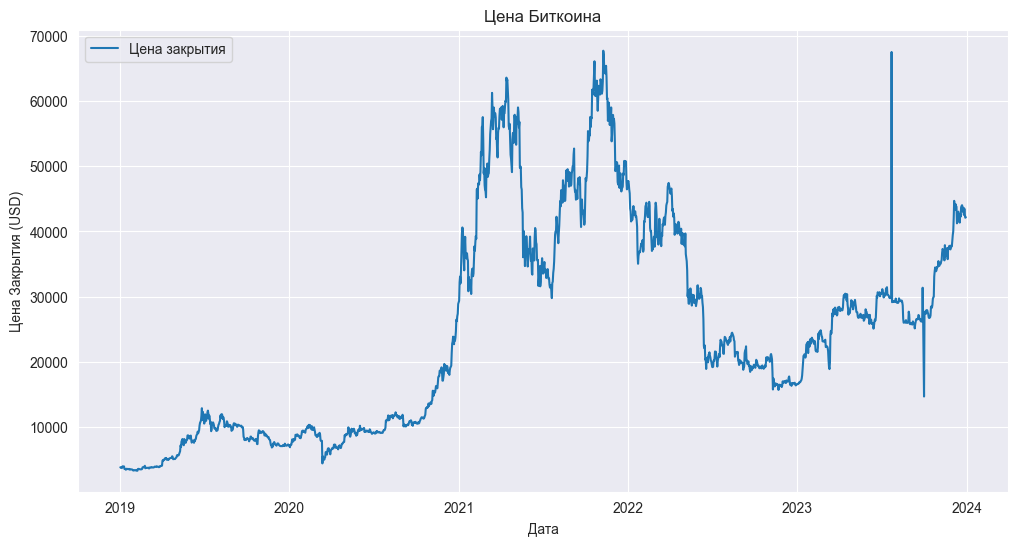

Размер обучающей выборки: 1460
Размер тестовой выборки: 365
Построение модели ARIMA...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24636.664, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24634.745, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24634.663, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24634.683, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24632.833, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.129 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -12315.417
Date:                Mon, 16 Dec 2024   AIC                          24632.833
Time:                        23:05:40   BIC                          24638.119
Sample:                    01-01-2019   HQIC                   

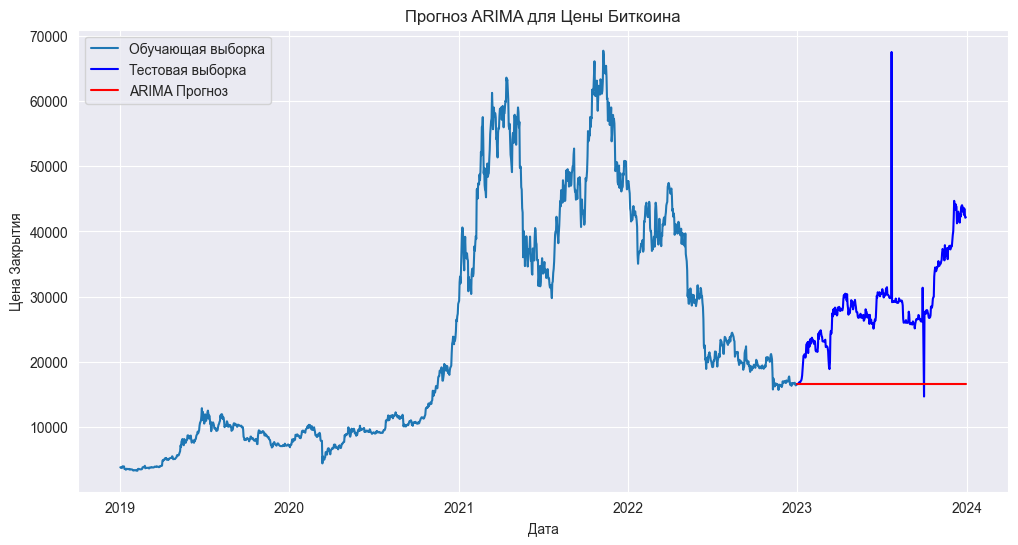

ARIMA MAPE: 3988.71%
ARIMA MSE: 189411971.75547945
ARIMA RMSE: 13762.702196715565
ARIMA MAE: 12235.968493150685


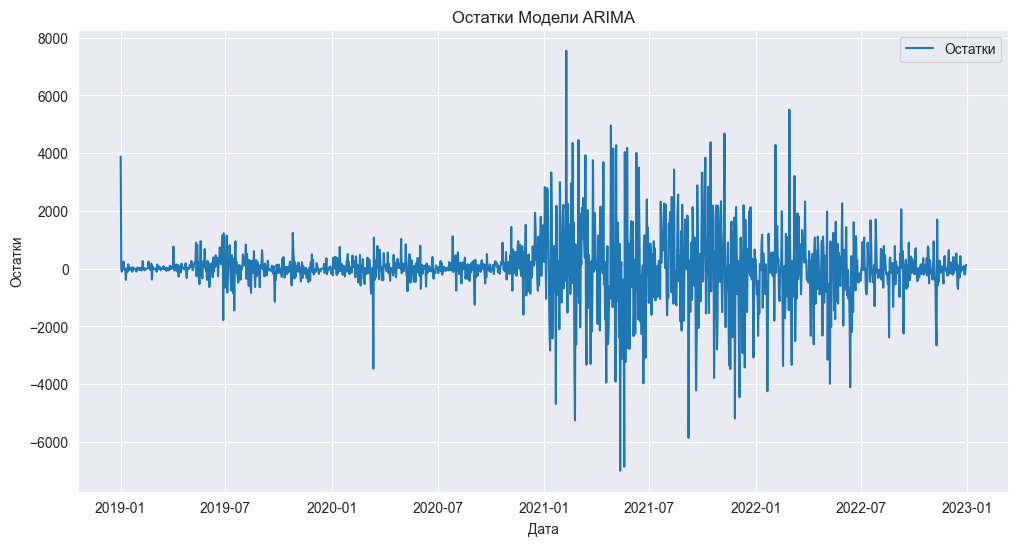

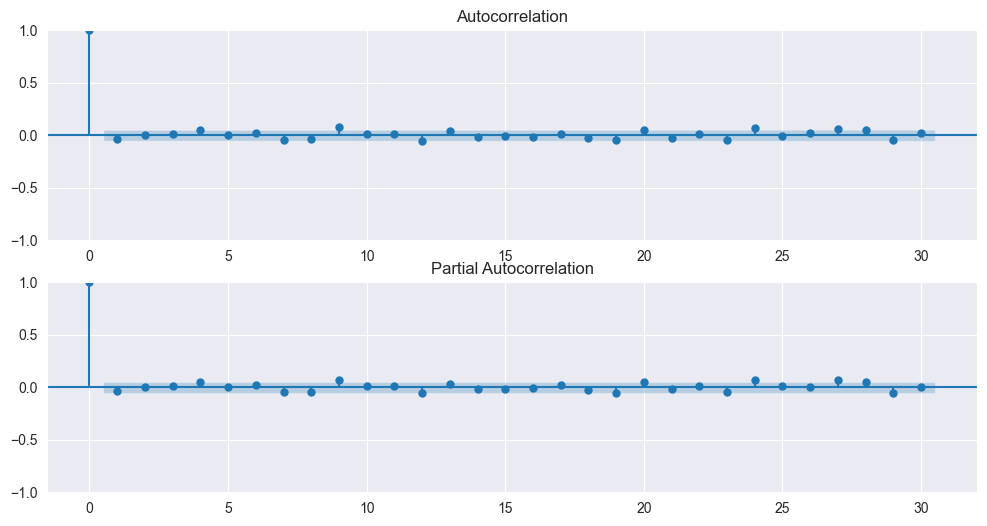

Построение модели SARIMA...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=25588.151, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=25147.823, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=25588.827, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=24981.850, Time=0.87 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.62 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=24984.773, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=24982.552, Time=1.03 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=24982.134, Time=0.66 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time=2.40 sec
 ARIMA(1,1,0)(2,1,0)[7] intercept   : AIC=24983.848, Time=0.99 sec

Best model:  ARIMA(1,1,0)(

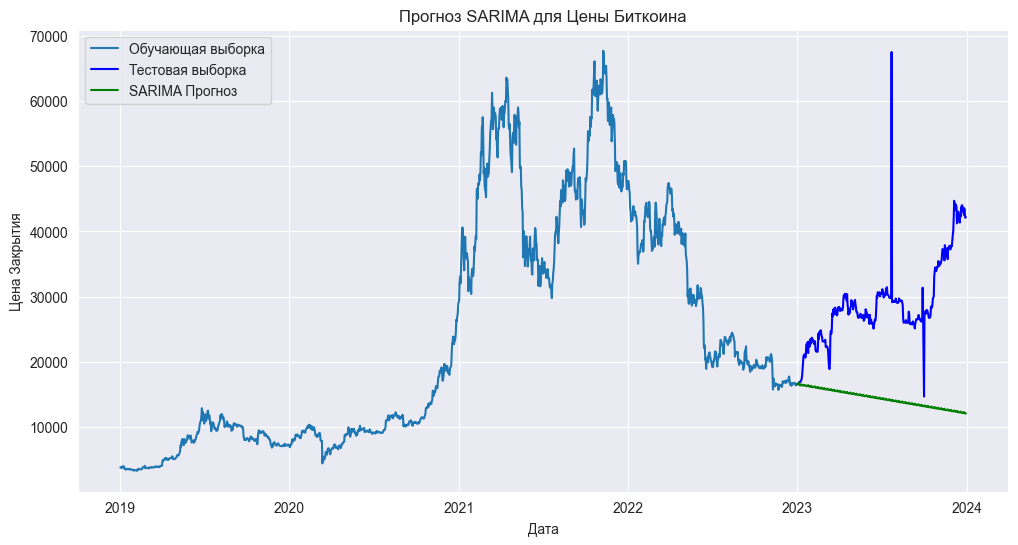

SARIMA MAPE: 4705.92%
SARIMA MSE: 262001812.72073665
SARIMA RMSE: 16186.470051272348
SARIMA MAE: 14427.526554363465


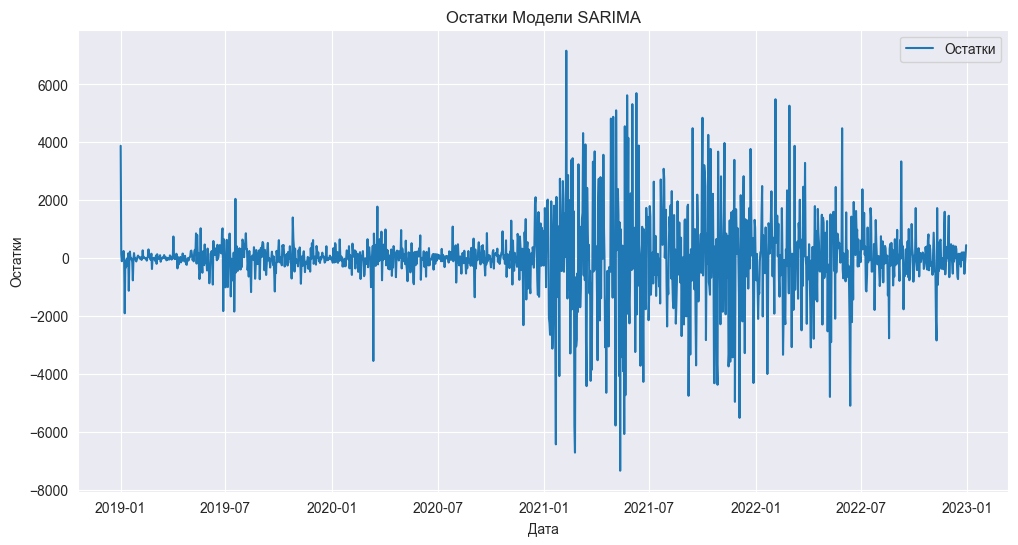

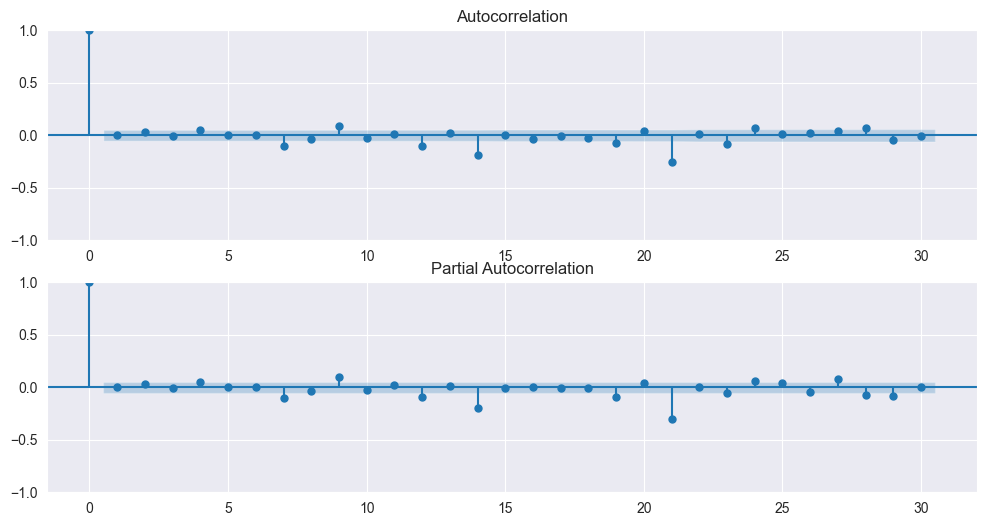

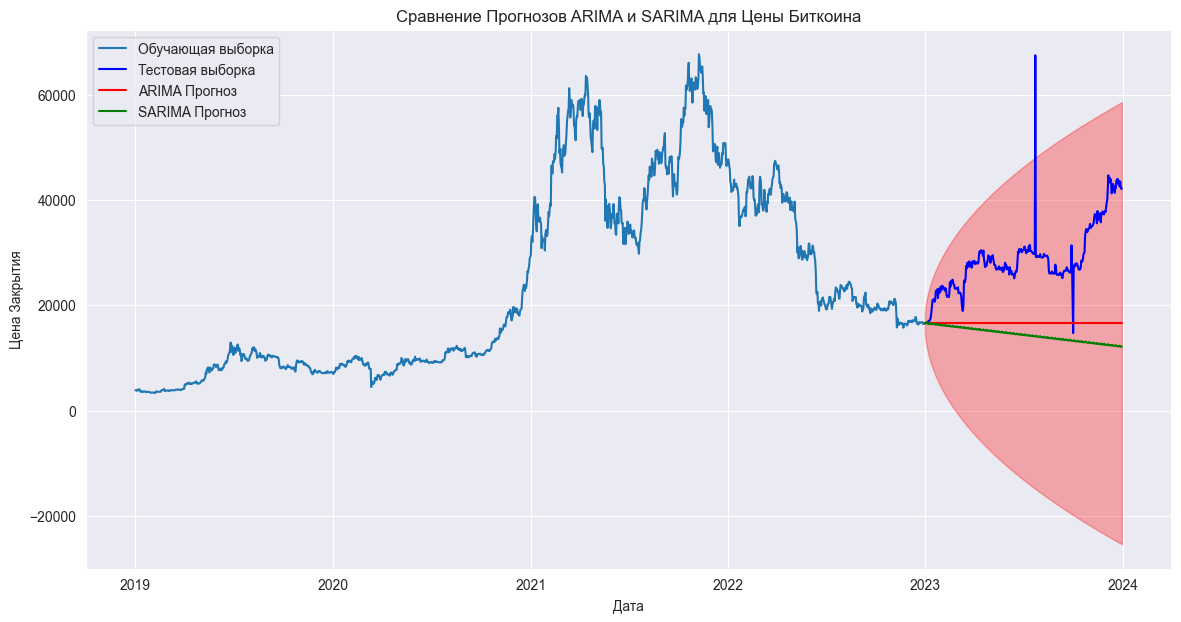

In [23]:
file_path = 'D:\\financial_time_series\\bitcoin_price_history.csv'

freq = 'D'

ts = load_and_preprocess(file_path, freq=freq)

plot_time_series(ts, title='Цена Биткоина', ylabel='Цена Закрытия (USD)')

train_size = int(len(ts) * 0.8)
ts_train, ts_test = ts[:train_size], ts[train_size:]
print(f"Размер обучающей выборки: {len(ts_train)}")
print(f"Размер тестовой выборки: {len(ts_test)}")

arima_model_obj, arima_forecast, arima_conf_int = arima_model(ts_train, ts_test, steps=len(ts_test))

plot_forecast(ts_train, ts_test, arima_forecast, arima_conf_int, title='Прогноз ARIMA для Цены Биткоина', color='red', label='ARIMA Прогноз')

arima_mse = mean_squared_error(ts_test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(ts_test, arima_forecast))
arima_mae = mean_absolute_error(ts_test, arima_forecast)

try:
    # Если используете sklearn >= 0.24
    arima_mape = mean_absolute_percentage_error(ts_test, arima_forecast) * 100
except AttributeError:
    # Альтернативная реализация, если mean_absolute_percentage_error недоступна
    arima_mape = np.mean(np.abs((ts_test - arima_forecast) / ts_test)) * 100
print(f"ARIMA MAPE: {arima_mape:.2f}%")
print(f"ARIMA MSE: {arima_mse}")
print(f"ARIMA RMSE: {arima_rmse}")
print(f"ARIMA MAE: {arima_mae}")

plot_residuals(arima_model_obj, title='Остатки Модели ARIMA')

seasonal_period = 7

sarima_model_obj, sarima_forecast, sarima_conf_int = sarima_model(ts_train, ts_test, seasonal_period=seasonal_period, steps=len(ts_test))

plot_forecast(ts_train, ts_test, sarima_forecast, sarima_conf_int, title='Прогноз SARIMA для Цены Биткоина', color='green', label='SARIMA Прогноз')

sarima_mse = mean_squared_error(ts_test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(ts_test, sarima_forecast))
sarima_mae = mean_absolute_error(ts_test, sarima_forecast)

try:
    # Если используете sklearn >= 0.24
    sarima_mape = mean_absolute_percentage_error(ts_test, sarima_forecast) * 100
except AttributeError:
    # Альтернативная реализация, если mean_absolute_percentage_error недоступна
    sarima_mape = np.mean(np.abs((ts_test - sarima_forecast) / ts_test)) * 100
print(f"SARIMA MAPE: {sarima_mape:.2f}%")
print(f"SARIMA MSE: {sarima_mse}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"SARIMA MAE: {sarima_mae}")

plot_residuals(sarima_model_obj, title='Остатки Модели SARIMA')

compare_forecasts(ts_train, ts_test, arima_forecast, arima_conf_int, sarima_forecast, sarima_conf_int)
